In [1]:

import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

from importlib import reload

import lina



In [2]:
9.6/10.2

0.9411764705882353

Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


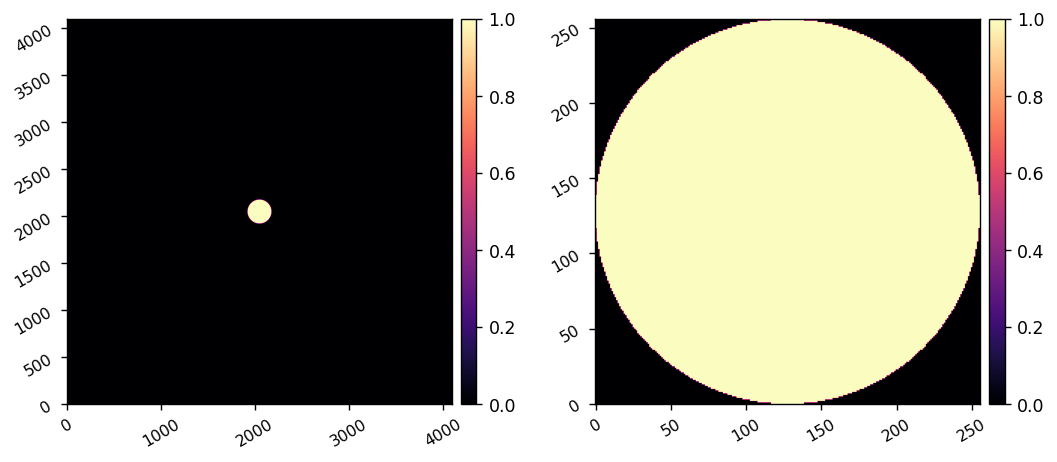

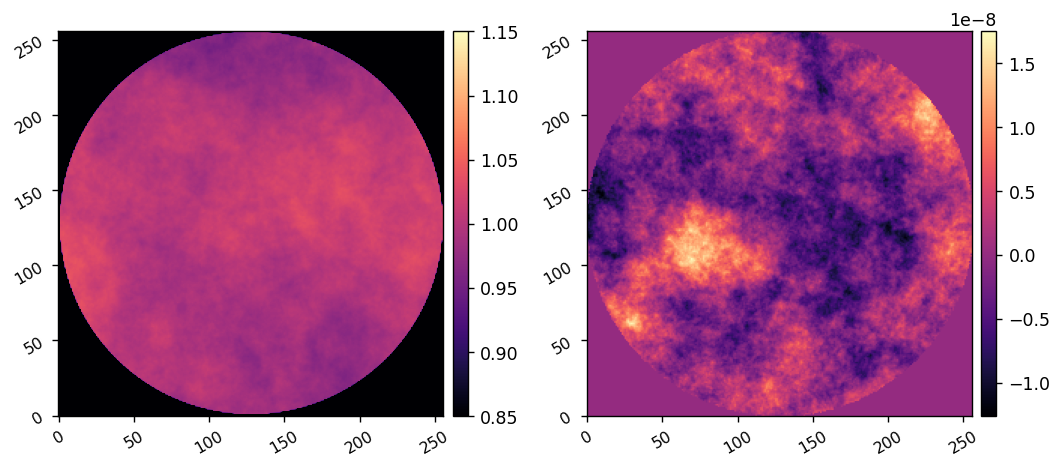

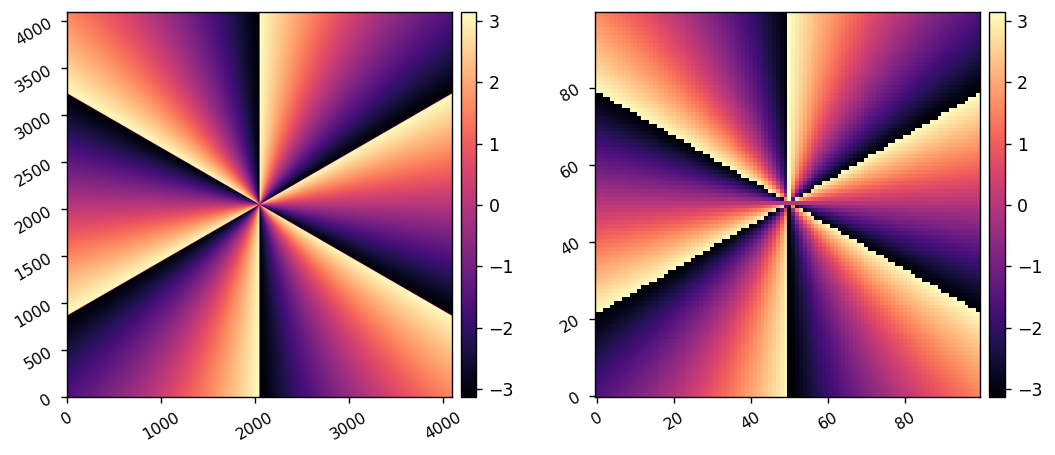

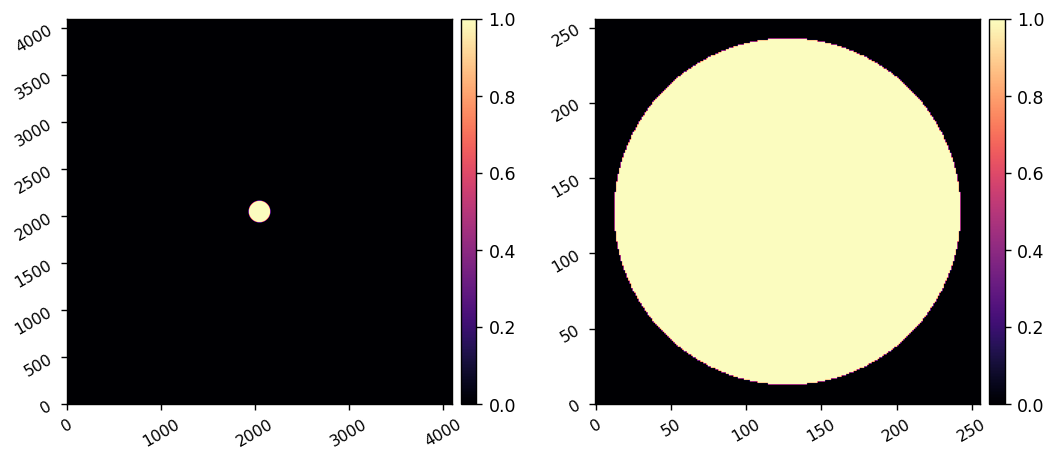

In [10]:
reload(cscoob)
reload(dm)
model = cscoob.SCOOB(npix=256, oversample=16, psf_pixelscale_lamD=1/3.05, dm_fill_factor=0.94)
imshow2(model.PUPIL, model.PUPIL, npix2=model.npix)

model.WFE = None
model.WFE = lina.utils.generate_wfe(model.pupil_diam, wavelength=500*u.nm,
                                opd_index=2.75, amp_index=3.0, 
                                opd_seed=1234, amp_seed=12345,
                                opd_rms=17*u.nm, amp_rms=0.05,
                                npix=model.npix, oversample=model.oversample,
                                plot=True)

VC = cscoob.make_vortex_phase_mask(model.focal_grid_pol, charge=6, 
                                #    singularity=20*u.um, 
                                   focal_length=500*u.mm, pupil_diam=9.7*u.mm, wavelength=632.8*u.nm)
imshow2(xp.angle(VC), xp.angle(scoobpsf.utils.pad_or_crop(VC, 100)))

model.LYOT = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
imshow2(model.LYOT, model.LYOT, npix2=model.npix)

In [4]:
model.reset_dm()

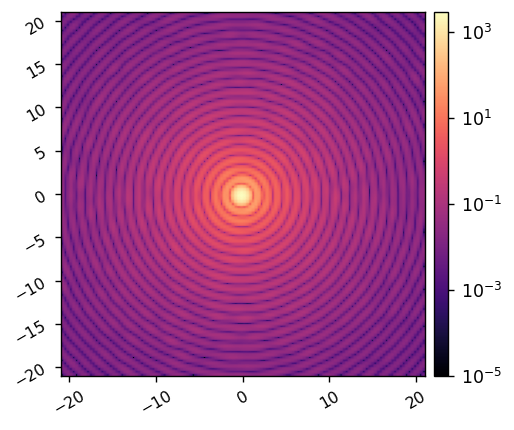

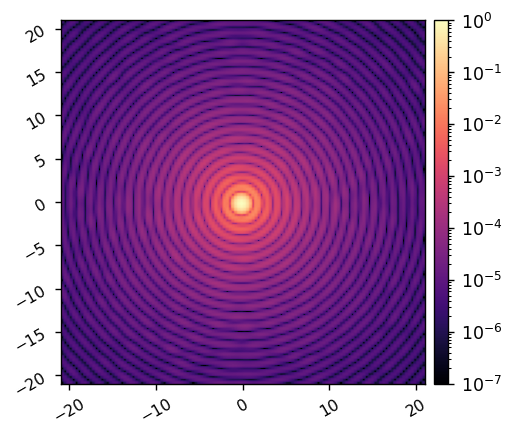

In [11]:
model.npsf = 128
model.FPM = None

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)

model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

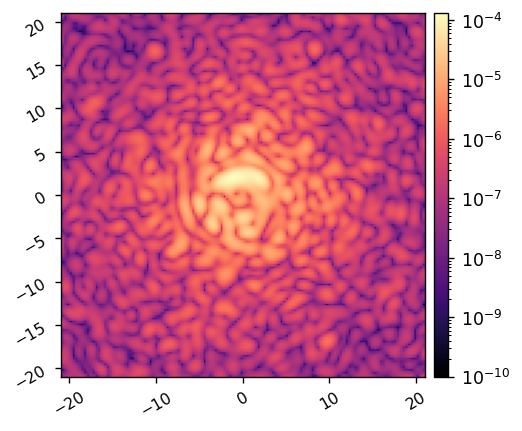

In [12]:
model.FPM = VC

model.FIELDSTOP = None
# model.FIELDSTOP = model.focal_grid_pol[0]<15

image = model.snap(plot=True, vmin=1e-10)

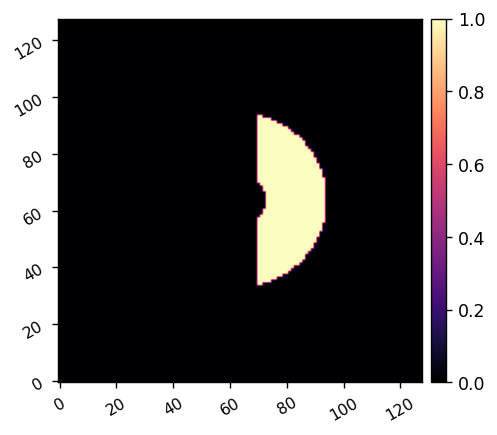

In [13]:
control_mask = lina.utils.create_annular_focal_plane_mask(model, 3, 10, 2, plot=True)

In [14]:
poke_modes = lina.utils.create_all_poke_modes(model.dm_mask)
response_matrix = lina.efc.calibrate(model, poke_modes, 1e-9, control_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=26.588 sec.
Jacobian built in 26.588 sec


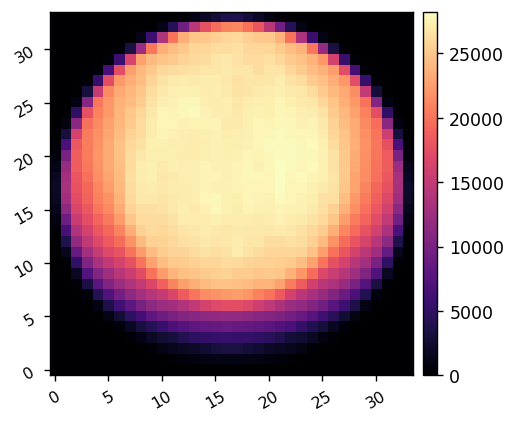

In [15]:
dm_response = xp.sqrt(xp.mean(xp.abs(response_matrix)**2, axis=0))
dm_response = model.DM.map_actuators_to_command(xp.asarray(dm_response))
imshow1(dm_response)

In [17]:
model.reset_dm()

images = xp.array([image])
estimates = xp.array([model.calc_wf()])
dm_commands = xp.array([model.get_dm()])

In [30]:
reg = 1e-2
# control_matrix = lina.utils.TikhonovInverse(jac, rcond=reg)
control_matrix = lina.utils.beta_reg(response_matrix, -4)

In [21]:
type(control_mask), control_mask

(cupy.ndarray,
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

Beginning closed-loop EFC.
	Running iteration 4/6.
Using model to compute electric field


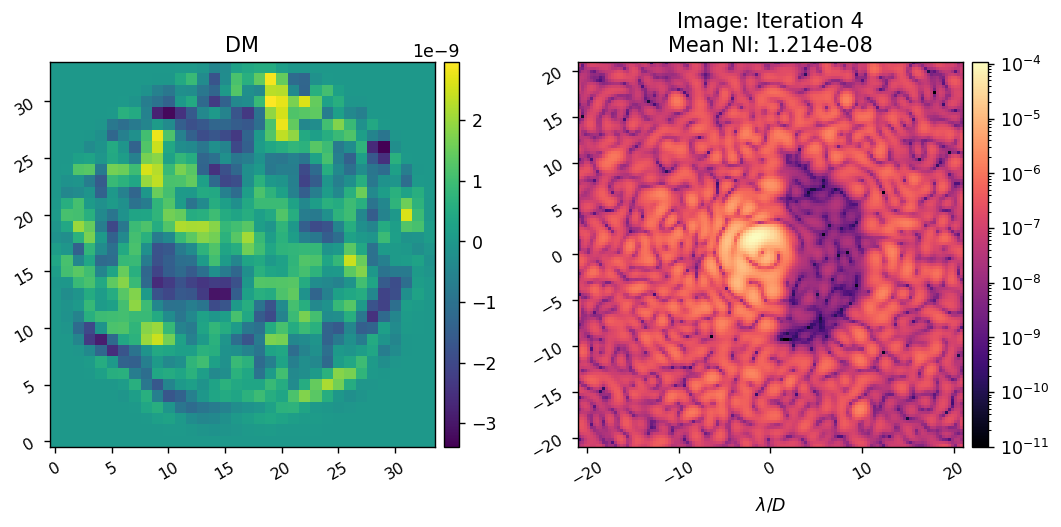

	Running iteration 5/6.
Using model to compute electric field


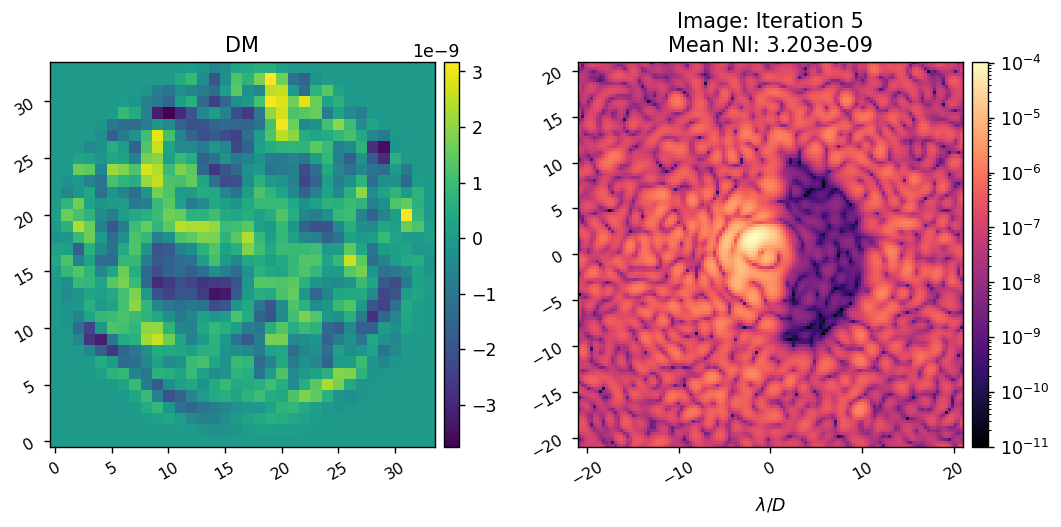

	Running iteration 6/6.
Using model to compute electric field


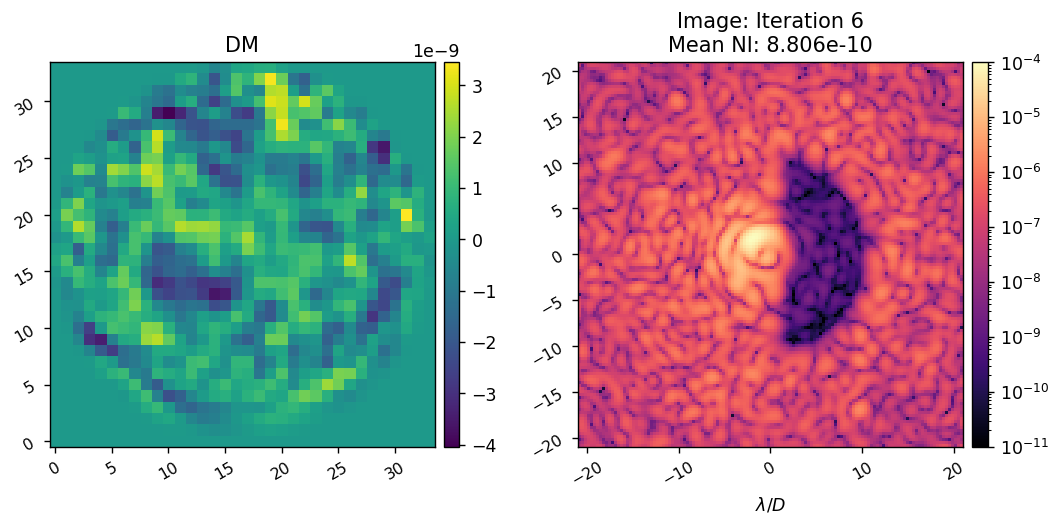

EFC completed in 1.758 sec.


In [31]:
reload(lina.efc)
images, estimates, dm_commands = lina.efc.run(model, 
                                                poke_modes,
                                                control_matrix,
                                                control_mask, 
                                                # est_fun=pwp_fun,
                                                # est_params=pwp_params,
                                                loop_gain=0.5, 
                                                leakage=0.0,
                                                iterations=3, 
                                                plot_all=True, 
                                                plot_current=True,
                                                plot_sms=False,
                                                plot_radial_contrast=False,
                                                old_images=images,
                                                old_fields=estimates,
                                                old_commands=dm_commands,
                                                    )

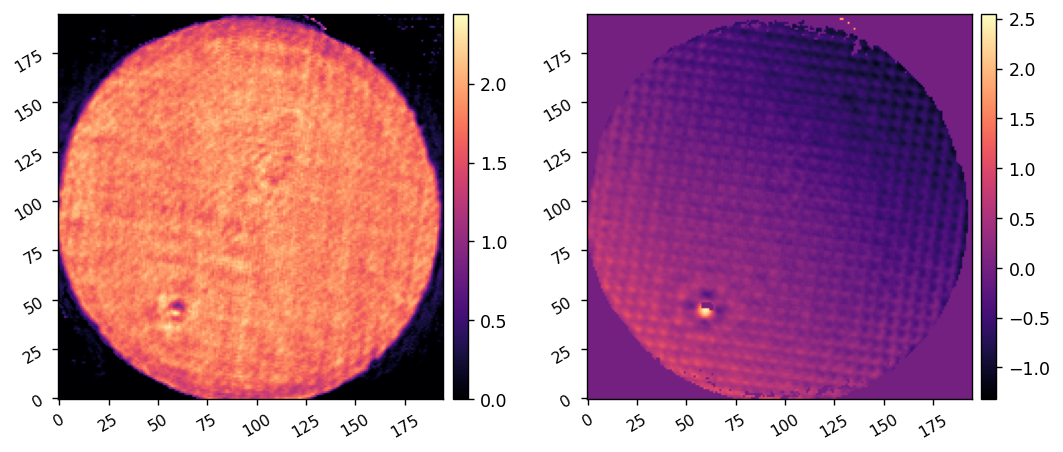

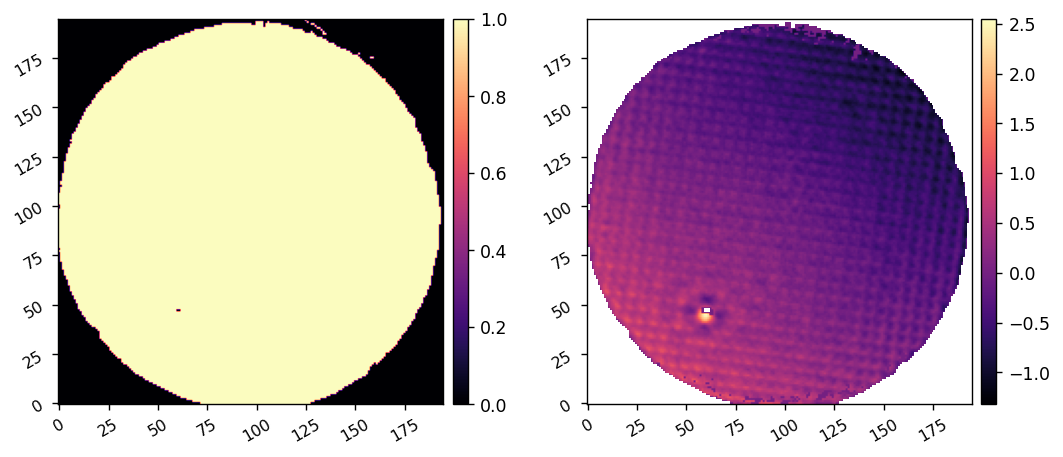

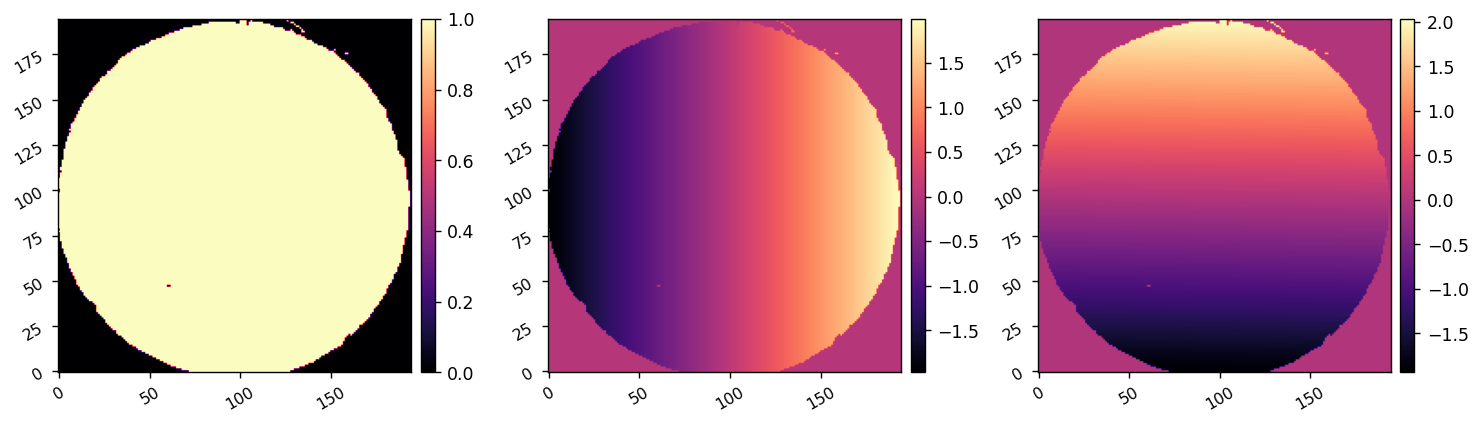

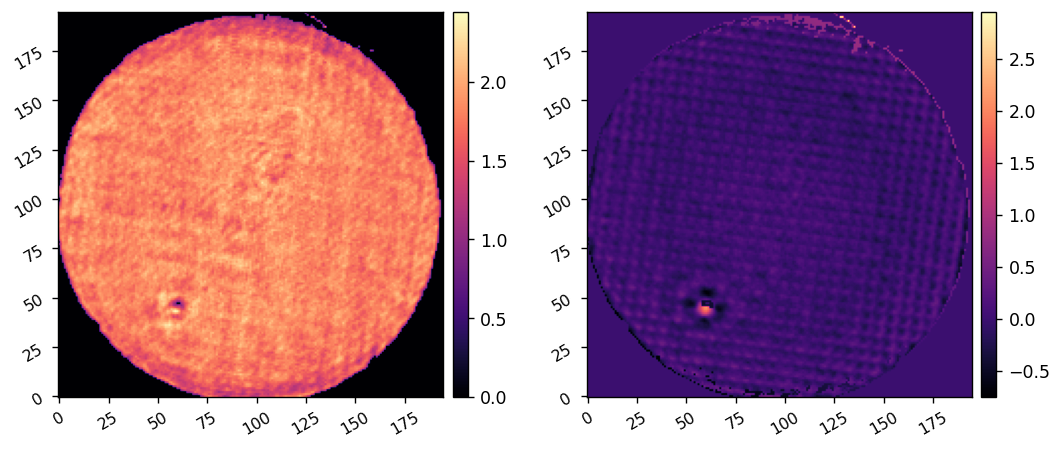

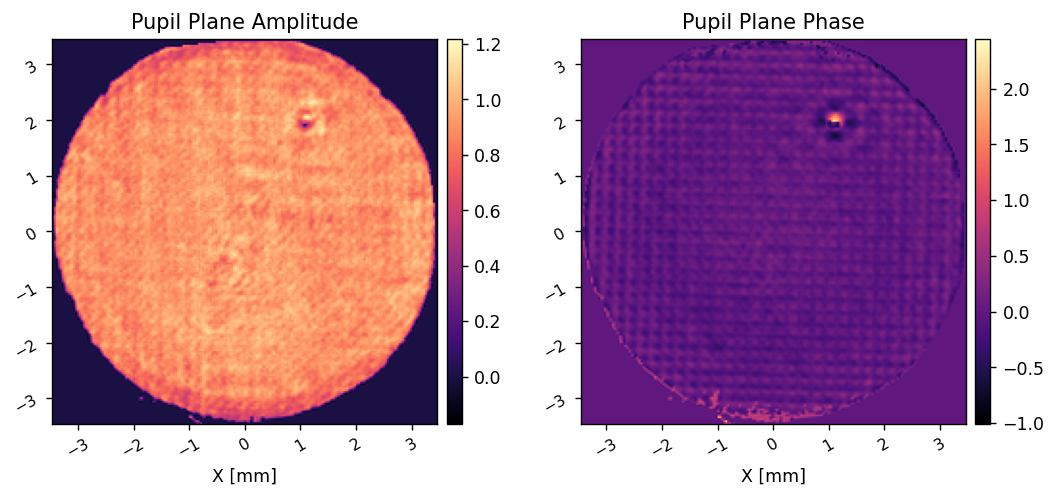

In [7]:
reload(scoobpsf.utils)

model.det_rotation = -7.5

pr_rotation = 180 + model.det_rotation + 1
wfe = scoobpsf.utils.process_pr_data('amp_est_20230925.fits', 'phase_est_20230925.fits',
                             195, pr_rotation, pixelscale=6.75*u.mm/(model.npix*u.pix),
                             remove_modes=3)

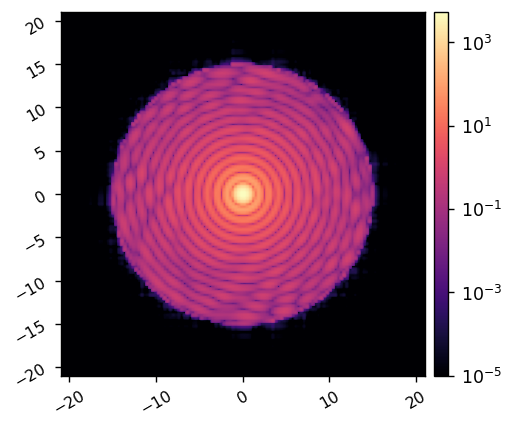

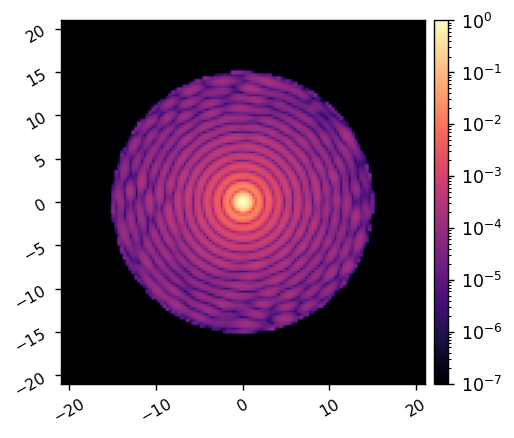

In [20]:
model.npsf = 128
model.WFE = scoobpsf.utils.pad_or_crop(wfe, model.N)
model.FPM = None

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)

model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)